# Connecting data challenge outputs to input truth #

This tutorial documents how to connect dc17a data challenge outputs
back to the input truth.  It uses the "dc17a-lite" subset available at NERSC in
```
/project/projectdirs/desi/datachallenge/dc17a-twopct/dc17a-lite.tar.gz
```
See https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting for
instructions on installing the DESI code.  The bottom of this tutorial lists the code versions used while testing this.

Stephen Bailey<br/>
June 2017

## Basic setup ##

The first portion of this tutorial doesn't require any DESI-specific code,
so just load the minimal set of external dependencies needed here.

In [1]:
import os
import numpy as np
import astropy.table
import desitutorials
%pylab inline

Populating the interactive namespace from numpy and matplotlib


For convenience, move into the directory where you unpacked the `dc17a-lite.tar.gz` file.  The following is where this is located at NERSC.

In [2]:
os.chdir('/project/projectdirs/desi/datachallenge/dc17a-lite/')
# os.chdir('/data/desi/datachallenge/dc17a-lite')

## Comparing the redshift catalog to the input truth ##

Read in the redshift catalog (zcat), targets, and truth file.
dc17a has a bug where string fields are padded with spaces,
so strip that off now.

In [3]:
zcat = astropy.table.Table.read('spectro/redux/dc17a2/zcat-dc17a2-lite.fits')
targets = astropy.table.Table.read('targets/targets-lite.fits')
truth = astropy.table.Table.read('targets/truth-lite.fits')

#- but in dc17a: string fields are padded with spaces; fix that
### print('Original set of template types:', set(truth['TEMPLATETYPE']))
truth['TEMPLATETYPE'][:] = np.char.strip(truth['TEMPLATETYPE'][:])
### print('Updated set of template types:', set(truth['TEMPLATETYPE']))

Let's look at what columns each of these tables has, and then merge the `zcat` and `truth` tables together.

In [4]:
def print_colnames(table_name, tx):
    print('{}.colnames:'.format(table_name))
    for i in range(0, len(tx.colnames), 8):
        print('    '+' '.join(tx.colnames[i:i+8]))

print_colnames('zcat', zcat)
print_colnames('targets', targets)
print_colnames('truth', truth)

zcat.colnames:
    CHI2 COEFF Z ZERR ZWARN SPECTYPE SUBTYPE TARGETID
    DELTACHI2 BRICKNAME
targets.colnames:
    TARGETID RA DEC DESI_TARGET BGS_TARGET MWS_TARGET SUBPRIORITY OBSCONDITIONS
    BRICKNAME DECAM_FLUX WISE_FLUX SHAPEEXP_R SHAPEEXP_E1 SHAPEEXP_E2 SHAPEDEV_R SHAPEDEV_E1
    SHAPEDEV_E2 DECAM_DEPTH DECAM_GALDEPTH EBV
truth.colnames:
    TARGETID MOCKID CONTAM_TARGET TRUEZ TRUESPECTYPE TEMPLATETYPE TEMPLATESUBTYPE TEMPLATEID
    SEED MAG DECAM_FLUX WISE_FLUX OIIFLUX HBETAFLUX TEFF LOGG
    FEH


In [5]:
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')
print_colnames('ztruth', ztruth)

ztruth.colnames:
    CHI2 COEFF Z ZERR ZWARN SPECTYPE SUBTYPE TARGETID
    DELTACHI2 BRICKNAME MOCKID CONTAM_TARGET TRUEZ TRUESPECTYPE TEMPLATETYPE TEMPLATESUBTYPE
    TEMPLATEID SEED MAG DECAM_FLUX WISE_FLUX OIIFLUX HBETAFLUX TEFF
    LOGG FEH


Make a histogram of $\Delta v = c (z - z_{true}) / (1 + z_{true})$ for each object type:

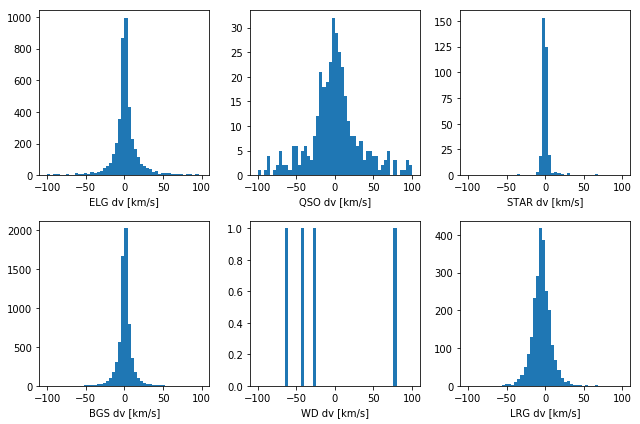

In [6]:
dv = 3e5 * (ztruth['Z'] - ztruth['TRUEZ']) / (1 + ztruth['TRUEZ'])
figure(figsize=(9,6))
for i, objtype in enumerate(set(ztruth['TEMPLATETYPE'])):
    subplot(2,3,1+i)
    ii = ztruth['TEMPLATETYPE'] == objtype
    hist(dv[ii], 50, (-100, 100))
    xlabel('{} dv [km/s]'.format(objtype))
tight_layout()

## Comparing spectra to truth

For this next section, we will use some `desispec` code so load that now and set
some environment variables so that `desispec.io` can find the data files.  This
assumes that we are still in the `dc17a-lite` directory.

In [7]:
import astropy.io.fits
import desispec.io
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.getcwd(), 'spectro/redux')
os.environ['SPECPROD'] = 'dc17a2'

Read some spectra and find out what bricks they are on

In [8]:
specfile = desispec.io.findfile('spectra', groupname='17244', nside=64)
spectra = desispec.io.read_spectra(specfile)

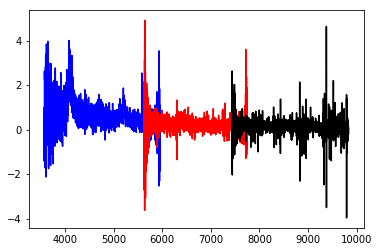

In [9]:
itarget = 7
plot(spectra.wave['b'], spectra.flux['b'][itarget], color='b')
plot(spectra.wave['r'], spectra.flux['r'][itarget], color='r')
plot(spectra.wave['z'], spectra.flux['z'][itarget], color='k')

In [10]:
spectra.fibermap['OBJTYPE', 'TARGETID', 'BRICKNAME', 'RA_TARGET', 'DEC_TARGET'][itarget]

OBJTYPE,TARGETID,BRICKNAME,RA_TARGET,DEC_TARGET
bytes10,int64,bytes8,float64,float64
SCIENCE,6946492816957564508,0084m085,8.45684623718,-8.61041545868


What's the truth and redrock fit results for this target?

In [11]:
ii = ztruth['TARGETID'] == spectra.fibermap['TARGETID'][itarget]
ztruth['TEMPLATETYPE', 'TRUEZ', 'SPECTYPE', 'Z', 'ZERR', 'ZWARN'][ii]

TEMPLATETYPE,TRUEZ,SPECTYPE,Z,ZERR,ZWARN
str10,float32,str6,float64,float64,int64
QSO,2.36204,QSO,2.36218577845,0.000367767469581,0


The actual true input spectra were not included with dc17a, but they are available at
NERSC in:
```
/project/projectdirs/desi/datachallenge/dc17a-twopct/targets/{group}/truth-{brickname}.fits
```
where `group = brickname[0:3]`, i.e. the first 3 characters of the brickname.

**NOTE**: future data challenges will group the input truth files by healpix like the output spectra, but dc17a did not.

The above target came from brickname 0084m085.  If you are running locally (not at NERSC), go get that file now, e.g.
```
mkdir -p targets/008/
scp edison.nersc.gov:/scratch2/scratchdirs/sjbailey/desi/dc17a/targets/008/truth-0084m085.fits targets/008/
```
Let's see what is in that file:

In [12]:
datadir = '/project/projectdirs/desi/datachallenge/dc17a-twopct'
fx = astropy.io.fits.open(datadir+'/targets/008/truth-0084m085.fits')
print(fx.info())
truewave = fx['WAVE'].data
trueflux = fx['FLUX'].data
truemeta = fx['TRUTH'].data

Filename: /project/projectdirs/desi/datachallenge/dc17a-twopct/targets/008/truth-0084m085.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU      12   (32001,)   float32   
  1  FLUX          1 ImageHDU         9   (32001, 298)   float32   
  2  TRUTH         1 BinTableHDU     72   298R x 17C   [K, K, K, E, 10A, 10A, 10A, J, K, E, 6E, 2E, E, E, E, E, E]   
None


It has the true wavelength, flux, and a TRUTH table which is just a subset
of the rows in the the truth file that we previously read.  Let's get the index for
the spectrum that we plotted above

In [13]:
itruth = np.where(truemeta['TARGETID'] == spectra.fibermap['TARGETID'][itarget])[0][0]

Does that look right?

**NOTE**: the truth templates are stored in units of erg/(s cm2 Angstrom) while
the output spectra are inunits of 1e-17 erg/(s cm2 Angstrom).  We might standardize that
in the future...

(-1, 3)

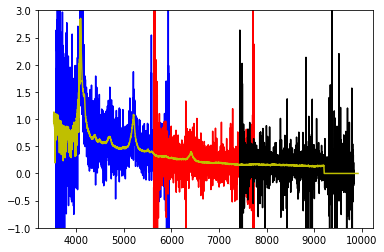

In [14]:
itarget = 7
plot(spectra.wave['b'], spectra.flux['b'][itarget], color='b')
plot(spectra.wave['r'], spectra.flux['r'][itarget], color='r')
plot(spectra.wave['z'], spectra.flux['z'][itarget], color='k')
plot(truewave, 1e17*trueflux[itruth], 'y-')
ylim(-1, 3)

**BUG**: Note the unphysical jump in the template around 9200 Angstrom;
That is the cause of many redshift failures, though redrock did get this one right.  That step has been fixed in later software releases.

## Further work
This tutorial used `astropy.table.Table` to read the catalogs
and `astropy.table.join` to merge them in a database-like manner.
This is convenient, but won't scale to the full DESI dataset.  Reading
files with `fitsio` and matching via numpy logic will be more scalable,
but is not yet documented here.

**TODO**: add example reading with fitsio and matching tables with numpy.

**TODO**: add a section on finding and querying the spectro catalog database.

## Code versions used ##
This is at the bottom of the tutorial so that python can introspect what was actually
used instead of just what we thought was used

In [15]:
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()

Code versions used for this tutorial:
python      : 3.6.6
numpy       : 1.13.3
scipy       : 1.1.0
astropy     : 2.0.7
yaml        : 3.12
matplotlib  : 2.1.2
desiutil    : 1.9.11
desispec    : 0.22.1
speclite    : 0.7
